In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation
import pandas as pd
import math
import tensorflow as tf
from lib.pinn import PINN
from lib.network import Network
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.set_printoptions(precision=3, suppress=True) 

In [4]:
# number of test samples
num_test_samples = 10

# system parameters
from parameters import p

In [5]:
network = Network.build(**p)

pinn = PINN(network, **p).build(**p)
pinn.compile(optimizer='adam', loss='mse')
if pathlib.Path("weights.h5").exists():
    pinn.load_weights("weights.h5")

In [13]:
x_train = tf.convert_to_tensor(np.random.rand(1000000, 1+p["dim"]) * p["max_dim"])
y = [tf.constant(0)]*3
network.compile(optimizer='adam', loss='mse')
y = np.zeros((1000000, 1))
network.fit(x_train, y)

31250/31250 [==============================] - 142s 5ms/step - loss: 4.8213e-04 - dense_3_loss: 1.1897e-04 - dense_4_loss: 2.8649e-04 - dense_5_loss: 7.6658e-05


[10000, 8000, 5000, 4000, 3000, 2000, 1000, 500, 100, 10, 1]
cpu time took: 5.1940
cpu time took: 2.5940
cpu time took: 0.7590
cpu time took: 0.4250
cpu time took: 0.2310
cpu time took: 0.0950
cpu time took: 0.0370
cpu time took: 0.0220
cpu time took: 0.0190
cpu time took: 0.0140
cpu time took: 0.0140
gpu time took: 0.5160
gpu time took: 0.1610
gpu time took: 0.0560
gpu time took: 0.0370
gpu time took: 0.0250
gpu time took: 0.0190
gpu time took: 0.0150
gpu time took: 0.0140
gpu time took: 0.0140
gpu time took: 0.0140
gpu time took: 0.0140


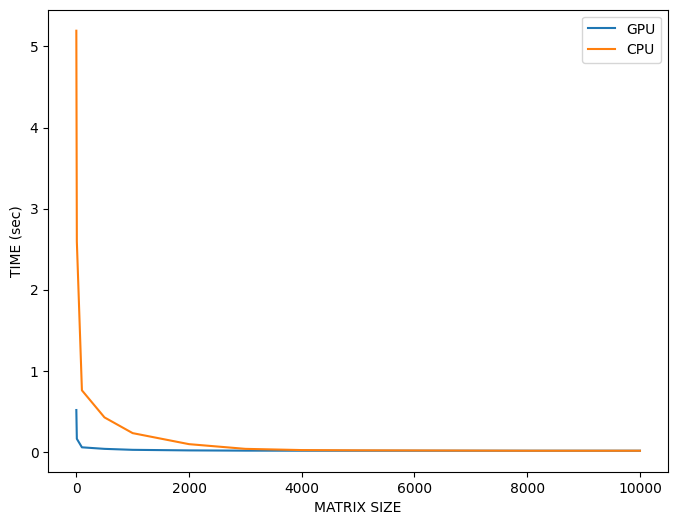

In [22]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt

#something of an extra or the below code will produce an error as "Tensor.graph is undefined when eager execution is enabled."
#this code is needed to not let tensorflow produce error for the cpu part of code or the gpu part.
#the reason for this error is because Session does not work with either eager execution or tf.function, and you should not invoke it directly.

tf.compat.v1.disable_eager_execution()

cpu_times = []
sizes = [1, 10, 100, 500, 1000, 2000, 3000, 4000, 5000, 8000, 10000]
sizes.reverse()
print(sizes)
for size in sizes:
    tf.compat.v1.reset_default_graph()
    start = time.time()
    with tf.device('cpu:0'):
        v1 = tf.Variable(tf.random.normal((size, size)))
        v2 = tf.Variable(tf.random.normal((size, size)))
        op = tf.matmul(v1, v2)

    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        sess.run(op)
    cpu_times.append(time.time() - start)
    print(f'cpu time took: {time.time() - start:.4f}')

gpu_times = []
for size in sizes:
    tf.compat.v1.reset_default_graph()
    start = time.time()
    with tf.device('gpu:0'):
        v1 = tf.Variable(tf.random.normal((size, size)))
        v2 = tf.Variable(tf.random.normal((size, size)))
        op = tf.matmul(v1, v2)

    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        sess.run(op)
    gpu_times.append(time.time() - start)
    print(f'gpu time took: {time.time() - start:.4f}')

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(sizes, gpu_times, label='GPU')
ax.plot(sizes, cpu_times, label='CPU')
plt.xlabel('MATRIX SIZE')
plt.ylabel('TIME (sec)')
plt.legend()
plt.show()

In [1]:
epochs=1000
n_train_samples = 100000

max_d = p["max_dim"][0:p["dim"]+1]

x_train = tf.convert_to_tensor(np.random.rand(n_train_samples, 1+p["dim"]) * max_d)
x_train_left = tf.convert_to_tensor(np.random.rand(n_train_samples, 1+p["dim"]) * max_d)
x_train_left[:,1] = 0
x_train_right = tf.convert_to_tensor(np.random.rand(n_train_samples, 1+p["dim"]) * max_d)
x_train_right[:,1] = 0
x=[x_train, x_train_left, x_train_right]

y = tf.convert_to_tensor([np.zeros((n_train_samples, 1))] * len(pinn.output_shape))


NameError: name 'p' is not defined

In [ ]:
pinn.fit(x=x, y=y, epochs=epochs)
# pinn.save_weights('weights.h5')


In [ ]:
num_test_samples = 30
dims = np.linspace(np.zeros(p["dim"]+1), p["max_dim"], num_test_samples).T
dims = np.split(dims.flatten(), p["dim"]+1)
mdims = np.meshgrid(*dims)
txyz = np.stack([mdim.flatten() for mdim in mdims], axis=-1)

In [ ]:
c, v, Fi = network.predict(txyz, batch_size=num_test_samples)

In [ ]:
c = c.reshape(mdims[0].shape)
time_t = 20
fig = plt.figure(figsize=(16, 4.5))

ax1 = fig.add_subplot(131,projection="3d")
# ax1.plot(dims[1], c[(0, slice(None),) + tuple(int(d/2) for d in p["max_dim"][2:])])
ax1.plot_surface(*np.meshgrid(dims[1], dims[2]), c[0])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("c")

ax2 = fig.add_subplot(132,projection="3d")
# ax1.plot(dims[1], c[(0, slice(None),) + tuple(int(d/2) for d in p["max_dim"][2:])])
ax2.plot_surface(*np.meshgrid(dims[1], dims[2]), c[10])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("c")

ax3 = fig.add_subplot(133,projection="3d")
# ax1.plot(dims[1], c[(0, slice(None),) + tuple(int(d/2) for d in p["max_dim"][2:])])
ax3.plot_surface(*np.meshgrid(dims[1], dims[2]), c[20])
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("c")

# ax2 = fig.add_subplot(132)
# xx, yy = np.meshgrid(x_flat, y_flat)
# v = v.reshape(t.shape + (3,))
# v_xy = v[time_t, :, :, int(p["max_z"]/2), 0:2]
# ax2.quiver(xx, yy, v_xy[..., 0], v_xy[..., 1])

# ax3 = fig.add_subplot(133)
# ax3.plot(x_flat, v[time_t, :, int(p["max_y"]/2), int(p["max_z"]/2), 0])

plt.show()


In [ ]:
network(np.array([[p["max_t"], p["max_x"], p["max_y"], p["max_z"]]]))

In [ ]:
np.meshgrid(np.zeros(2), np.zeros(3))

In [ ]:
n_test_samples = 2
max_d = np.array([p["max_t"], p["max_x"], p["max_y"], p["max_z"]])
x_train = np.random.rand(n_test_samples, 4) * max_d
x_train_left = np.random.rand(n_test_samples, 4) * max_d
x_train_left[:,1] = 0
x_train_right = np.random.rand(n_test_samples, 4) * max_d
x_train_right[:,1] = 0
x=[x_train, x_train_left, x_train_right]
for i, xx in enumerate(pinn(x)):
    print(i, ":", xx.shape)
